In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import unet
import tensorflow as tf
from typing import Tuple, List
#from PIL import Image
#from numpy import asarray
#from skimage.transform import resize
import random

In [82]:
DATASET_PATH = "/Users/jiehyun/kaggle/"
IMAGE_DATASET_PATH = DATASET_PATH + "input/hubmap-organ-segmentation/train_images"
MASK_DATASET_PATH = DATASET_PATH + "input/hubmap-organ-segmentation/binary_masks"
TRAIN_CSV = DATASET_PATH + "input/hubmap-organ-segmentation/train.csv"
train_df = pd.read_csv(TRAIN_CSV)
TOTAL_NUM_DATA = 351
OUTPUT_FOLDER = "/Users/jiehyun/kaggle/output/"
IMG_NPY_512 = OUTPUT_FOLDER + 'img_npy_512'
MASK_NPY_512 = OUTPUT_FOLDER + 'mask_npy_512'

In [83]:
IMAGE_SIZE = (512, 512) 
channels = 3
classes = 4

In [91]:
def load_data(count:int, splits:Tuple[float]=(0.71, 0.145, 0.145), **kwargs) -> List[tf.data.Dataset]:
    return [tf.data.Dataset.from_tensor_slices(_build_samples(int(split * count), **kwargs)) for split in splits]


def _build_samples(sample_count:int, **kwargs) -> Tuple[np.array, np.array]:
    
    loadedimages = []
    loadedmasks = []

    for i in range(len(train_df['id'])):
        idx = random.randint(0, len(train_df) - 1)
        img_id = train_df['id'][idx]
        loadedimages += [np.load(IMG_NPY_512 + f'/{img_id}.npy', allow_pickle=True).copy()]
        loadedmasks += [np.load(MASK_NPY_512 + f'/{img_id}.npy', allow_pickle=True).copy()]
    
    # now let's go to numpyland
    images = np.empty((sample_count, IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    labels = np.empty((sample_count, IMAGE_SIZE[0], IMAGE_SIZE[1], 4))
    
    for i in range(sample_count):
        image, mask = loadedimages[i], loadedmasks[i]
        #image, mask = loadedimages, loadedmasks

        image = image.reshape((IMAGE_SIZE[0], IMAGE_SIZE[1], 3)).astype(np.float32)
        mask = mask.reshape((IMAGE_SIZE[0], IMAGE_SIZE[1], 1)).astype(np.float32)

        image = tf.cast(image, tf.float32)/255.0
        mask -= 1
        #
        # Use Tensorflow to flip the image horizontally
        #
        if tf.random.uniform(()) > 0.5:
            image = tf.image.flip_left_right(image)
            mask = tf.image.flip_left_right(mask)
        #
        # Use Tensorflow to flip the image vertically
        #
        if tf.random.uniform(()) > 0.5:
            image = tf.image.flip_up_down(image)
            mask = tf.image.flip_up_down(mask)
        #
        # Use Tensorflow to rotate the image 90 degrees
        #
        if tf.random.uniform(()) > 0.5:
            image = tf.image.rot90(image, k=1, name=None)
            mask = tf.image.rot90(mask, k=1, name=None)
        
        # augmentation done, let's store the image
        images[i] = image
        #images = image

        
        # here we split the mask to background and foreground
        fg = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 1), dtype=np.bool_)
        fg[mask == 255] = 1
        bg = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 1), dtype=np.bool_)
        bg[mask == 0] = 1
        
        labels[i, :, :, 0] = bg[:,:,0]
        labels[i, :, :, 1] = fg[:,:,0]
        #labels[:,:,0] = bg[:,:,0]
        #labels[:,:,1] = fg[:,:,0]
        
    return images, labels

In [92]:
train, val, test = load_data(TOTAL_NUM_DATA, splits=(0.71, 0.145, 0.145))

In [93]:
LEARNING_RATE = 1e-3

unet_model = unet.build_model(channels=channels,
                              num_classes=classes,
                              layer_depth=5,
                              filters_root=64,
                              padding="same")

unet.finalize_model(unet_model, learning_rate=LEARNING_RATE)

In [94]:
trainer = unet.Trainer(checkpoint_callback=False,
                       learning_rate_scheduler=unet.SchedulerType.WARMUP_LINEAR_DECAY,
                       warmup_proportion=0.1,
                       learning_rate=LEARNING_RATE)

In [95]:
trainer.fit(unet_model,
            train,
            val,
            epochs=1,
            batch_size=10
            )

#epochs=50

25/25 [==============================] - 1576s 63s/step - loss: 0.0014 - categorical_crossentropy: 0.0014 - categorical_accuracy: 0.8631 - mean_iou: 2.4936e-04 - dice_coefficient: 5.0121e-04 - auc_5: 0.4788 - learning_rate: 4.8244e-04 - val_loss: 0.0016 - val_categorical_crossentropy: 0.0016 - val_categorical_accuracy: 1.0000 - val_mean_iou: 2.8288e-04 - val_dice_coefficient: 5.7223e-04 - val_auc_5: 0.5000


1/1 [==============================] - 2s 2s/step


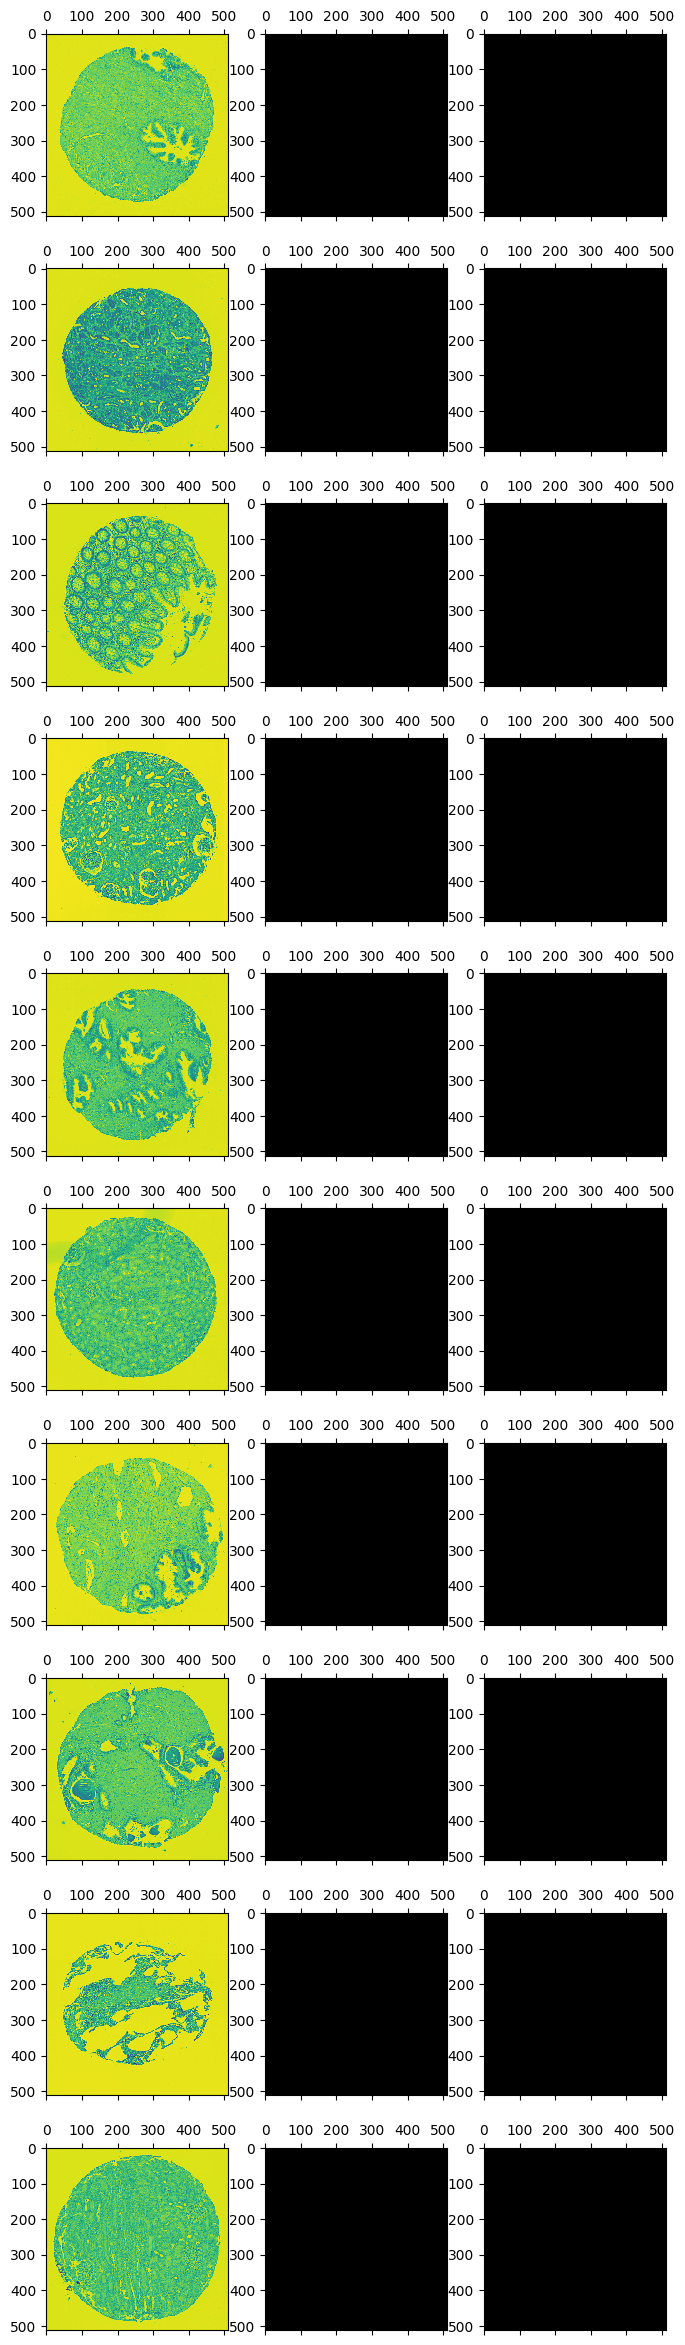

In [96]:
rows = 10
fig, axs = plt.subplots(rows, 3, figsize=(8, 30))

for ax, (image, label) in zip(axs, test.take(rows).batch(1)):
  prediction = unet_model.predict(image)
  ax[0].matshow(image[0, :, :, 0])
  ax[1].matshow(label[0, :, :, 1], cmap="gray")
  ax[2].matshow(prediction[0].argmax(axis=-1), cmap="gray")

In [97]:
print(prediction[0].shape)

(512, 512, 4)


In [98]:
print(unet_model.summary())

Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv_block_45 (ConvBlock)      (None, None, None,   38720       ['inputs[0][0]']                 
                                64)                                                               
                                                                                                  
 max_pooling2d_20 (MaxPooling2D  (None, None, None,   0          ['conv_block_45[0][0]']          
 )                              64)                                                            